# Проект "Промышленность"

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

<b>Описание этапа обработки стали</b>  
  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.   

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

<b>Описание данных</b> 

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

!pip install pandas -U  
!pip install matplotlib -U  
!pip install seaborn -U  
!pip install lightgbm -U  
!pip install sklearn -U

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm

In [2]:
def observe(name):
    data = pd.read_csv('/datasets/final_steel/' + name)
    print('\033[1m'+'Общая информация о данных'+'\033[0m', end='\n')
    print()
    print(data.info())
    print()
    print()
    print('\033[1m'+'Описательные статистики'+'\033[0m')
    display(data.describe())
    print()
    print()
    print('\033[1m'+'Первые строки из данных'+'\033[0m')
    display(data.head())
    return data

### data_arc.csv — данные об электродах

In [3]:
data_arc = observe('data_arc.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


Описательные статистики


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388




Первые строки из данных


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Перед нами набор данных, относящиеся к этапу производства, на котором расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.
  
Данные включают в себя следующие столбцы:
- key - номер партии
- Начало нагрева дугой - момент времени, в котором начался нагрев
- Конец нагрева дугой - момент времени, в котором закончился нагрев
- Активная мощность
- Реактивная мощность

В данных нет пропущенных значений.
Отметим, что столбцы "Начало нагрева дугой" и "Конец нагрева дугой" имеют текстовый формат, а не формат даты-времени.

Из предварительного обсуждения проекта известно, что для решения нашей задачи мы должны использовать данные только об активной мощности.

Для более глубокого анализа переведем в формат даты-времени соответствующие столбцы.

In [4]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(
    data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(
    data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Для лучшего понимания данных дополнительно посмотрим, сколько в среднем по времени нагревают сталь. 

In [6]:
data_arc['Продолжительность нагревания'] = data_arc['Конец нагрева дугой'] - \
    data_arc['Начало нагрева дугой']
data_arc['Продолжительность нагревания'] = data_arc['Продолжительность нагревания'].astype(
    'timedelta64[s]')

In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагревания
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0


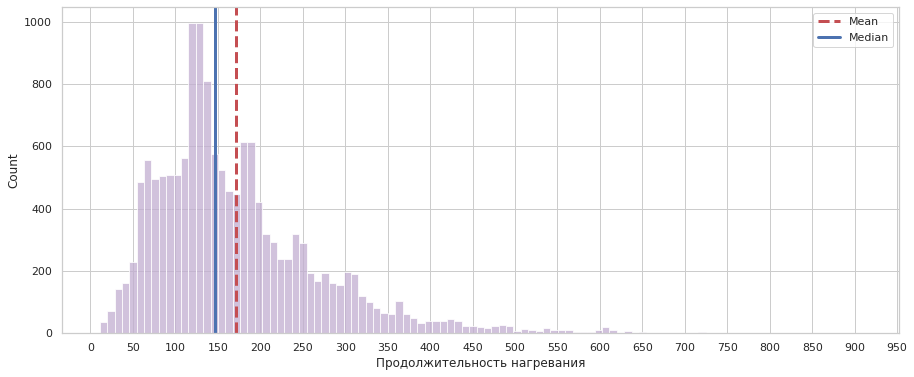

In [8]:
mean = data_arc['Продолжительность нагревания'].mean()
median = data_arc['Продолжительность нагревания'].median()
sns.set(rc={'figure.figsize': (15, 6)})
sns.set_style("whitegrid")
graph = sns.histplot(
    data=data_arc, x="Продолжительность нагревания", color='#c2aed1')
plt.axvline(mean, color='r', linestyle='--', label="Mean", linewidth=3)
plt.axvline(median, color='b', linestyle='-', label="Median", linewidth=3)
graph.set_xticks(np.arange(0, 1000, 50))
plt.legend()
plt.show()

In [9]:
data_arc['Продолжительность нагревания'].to_frame().describe()

,Продолжительность нагревания
count,14876.000000
mean,171.670946
std,98.186803
min,11.000000
25%,107.000000
50%,147.000000
75%,214.000000
max,907.000000


<b> Выводы </b>  

Как видно на графике и в таблице выше, в среднем одно нагревание стали составляет 172 секунды.
Обращает на себя внимание, что есть как очень короткие по продолжительности нагревания (11 сек.), так и длительные (907 сек.)

На текущем этапе представляется, что для построения модели необходимо будет понять, сколько энергии передано на нагревание одного ковша (активная мощность &times; длительность нагревания)

### data_bulk.csv — данные о подаче сыпучих материалов (объём)

In [10]:
data_bulk = observe('data_bulk.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


Описательные статистики


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000




Первые строки из данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<b> Выводы </b>  

Перед нами таблица из 3129 строк. В таблице есть столбец key (номер партии) и столбцы bulk (вероятно, обозначающих тот или иной вид сыпучих материалов). Во всех столбцах есть пропуски, скорее всего они означают, что тот или иной сыпучий материал не подавался.

### data_bulk_time.csv — данные о подаче сыпучих материалов (время)

In [11]:
data_bulk_time = observe('data_bulk_time.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


Описательные статистики


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000




Первые строки из данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<b> Выводы </b>  

Перед нами время подачи сыпучих материалов. 

### data_gas.csv — данные о продувке сплава газом

In [12]:
data_gas = observe('data_gas.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


Описательные статистики


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040




Первые строки из данных


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<b> Выводы </b>  

Вероятно, в таблице указан объем газа для каждой партии. Данные о газе могут иметь важное значение для модели, однако нам неизвестно время продувки газом, так что мы не можем использовать эти данные.

### data_temp.csv — результаты измерения температуры;

In [13]:
data_temp = observe('data_temp.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


Описательные статистики


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000




Первые строки из данных


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<b> Выводы </b>

В таблице представлены результаты измерения температуры для разных партий в разное время. В соответствии с задачей целевым признаком является последнее измерение температуры для партии.

### data_wire.csv — данные о проволочных материалах (объём)

In [14]:
data_wire = observe('data_wire.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


Описательные статистики


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604




Первые строки из данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b> Выводы </b>

Данная информация соответствует этапу "сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат"

### data_wire_time.csv — данные о проволочных материалах (время)

In [15]:
data_wire_time = observe('data_wire_time.csv')

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


Описательные статистики


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000




Первые строки из данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b> Выводы </b>

Данная информация показывает время добавления проволочных материалов

## План работы

1. Создать единый датасет из набора файлов. Для этого следует выбрать целевой признак и избавиться от лишней информации.
- Целевым признаком является последнее измерение температуры для конкретной в файле data_temp.csv. Из этого же файла необходимо извлечь первое измерение температуры и использовать это как признак.
- Далее следует определить одним из признаков - количество переданной энергии во время нагревания электродами. Его можно извлечь из файле data_arc.csv. Для этого необходимо для каждой партии получить сумму произведений активной мощности на длительность нагревания. При этом необходимо будет убедиться, что временные промежутки нагревания находятся между первым и последнем замером температуры для партии.
- Также признаками будут являться количество переданных сыпучих материалов и проволки между первым и последним замерами темпаратуры в разрезе по видам сыпучих материалов и проволки (файлы data_bulk.csv, data_bulk_time.csv, data_wire.csv, data_wire_time.csv). Файлы со временем нам нужны только для того, чтобы избавиться от данных, выходящих за пределы первого и последнего замера. Пропущенные значения объема сыпучих материалов и проволки следует заменить на нули.
- Далее необходимо объединить данные файлы по столбцу key.

2. Получив единый датасет, необходимо сделать масштабирование признаков.<p>
3. Разделить выборку на обучающую и тестовую.  <p>
  
4. Обучить несколько моделей регрессии на обучающих данных.  <p>
  
5. Проверить модель на тестовых данных.  <p>
  
6. Подготовить отчет с основными выводами и результатами работы.  <p>

## Предобработка данных

Так как целевой признак - температура, начнем с обработки данного датасета.

### data_temp.csv — результаты измерения температуры

В начале переименуем столбцы

In [16]:
data_temp.columns = ['key', 'measurement_time', 'temp']

In [17]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               15907 non-null  int64  
 1   measurement_time  15907 non-null  object 
 2   temp              13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [18]:
data_temp

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Далее изменим тип данных столбца "measurement_time" на формат даты-времени

In [19]:
data_temp['measurement_time'] = pd.to_datetime(
    data_temp['measurement_time'], format='%Y-%m-%d %H:%M:%S')

In [20]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               15907 non-null  int64         
 1   measurement_time  15907 non-null  datetime64[ns]
 2   temp              13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Очистим данные от пропусков

In [21]:
data_temp = data_temp.dropna().reset_index(drop=True)

In [22]:
data_temp

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0
13002,3238,2019-08-31 23:30:31,1584.0
13003,3239,2019-09-01 01:31:47,1598.0
13004,3240,2019-09-01 02:39:01,1617.0


In [23]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               13006 non-null  int64         
 1   measurement_time  13006 non-null  datetime64[ns]
 2   temp              13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 305.0 KB


Для обучения модели нам необходимы данные о партиях, для которых есть хотя бы два измерения температуры, поэтому очистим данные от партий, для которых есть только одно измерение темпартуры.

In [24]:
key_temp_counts = data_temp.groupby(
    by=['key'])['temp'].count().to_frame(name='counts').reset_index()

display(key_temp_counts)

,key,counts
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
...,...,...
3211,3237,1
3212,3238,1
3213,3239,1
3214,3240,1


In [25]:
data_temp = data_temp.merge(key_temp_counts, on='key', how='left')
display(data_temp)

,key,measurement_time,temp,counts
0,1,2019-05-03 11:16:18,1571.0,5
1,1,2019-05-03 11:25:53,1604.0,5
2,1,2019-05-03 11:29:11,1618.0,5
3,1,2019-05-03 11:30:01,1601.0,5
4,1,2019-05-03 11:30:39,1613.0,5
...,...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0,1
13002,3238,2019-08-31 23:30:31,1584.0,1
13003,3239,2019-09-01 01:31:47,1598.0,1
13004,3240,2019-09-01 02:39:01,1617.0,1


In [26]:
data_temp = data_temp[data_temp['counts'] > 1].reset_index(drop=True)
display(data_temp)

,key,measurement_time,temp,counts
0,1,2019-05-03 11:16:18,1571.0,5
1,1,2019-05-03 11:25:53,1604.0,5
2,1,2019-05-03 11:29:11,1618.0,5
3,1,2019-05-03 11:30:01,1601.0,5
4,1,2019-05-03 11:30:39,1613.0,5
...,...,...,...,...
12260,2498,2019-08-06 02:19:26,1593.0,5
12261,2498,2019-08-06 02:25:31,1594.0,5
12262,2499,2019-08-06 02:40:25,1569.0,3
12263,2499,2019-08-06 02:54:24,1604.0,3


In [27]:
data_temp = data_temp[['key', 'measurement_time', 'temp']
                      ].sort_values(by=['key', 'measurement_time'])
display(data_temp.head(10))

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Далее нам необходимо оставить только первое и последнее измерение для каждой партии

In [28]:
data_temp = data_temp.groupby('key').apply(lambda x: x.iloc[[0, -1]])
display(data_temp)

key    measurement_time    temp
key                                         
1    0         1 2019-05-03 11:16:18  1571.0
     4         1 2019-05-03 11:30:39  1613.0
2    5         2 2019-05-03 11:37:27  1581.0
     10        2 2019-05-03 11:59:12  1602.0
3    11        3 2019-05-03 12:13:17  1596.0
...          ...                 ...     ...
2497 12256  2497 2019-08-06 01:53:50  1589.0
2498 12257  2498 2019-08-06 02:03:49  1591.0
     12261  2498 2019-08-06 02:25:31  1594.0
2499 12262  2499 2019-08-06 02:40:25  1569.0
     12264  2499 2019-08-06 03:00:28  1603.0

[4950 rows x 3 columns]

In [29]:
data_temp.index = data_temp.index.droplevel(0)
data_temp = data_temp.reset_index(drop=True)
display(data_temp)

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:30:39,1613.0
2,2,2019-05-03 11:37:27,1581.0
3,2,2019-05-03 11:59:12,1602.0
4,3,2019-05-03 12:13:17,1596.0
...,...,...,...
4945,2497,2019-08-06 01:53:50,1589.0
4946,2498,2019-08-06 02:03:49,1591.0
4947,2498,2019-08-06 02:25:31,1594.0
4948,2499,2019-08-06 02:40:25,1569.0


Теперь в полученном датасете необходимо строки трансформировать в столбцы, чтобы столбцы соответствовали следующим данным:
- время первого замера
- температура первого замера
- время последнего замера
- температура последнего замера.

In [30]:
data_temp = pd.DataFrame({'key': data_temp['key'].iloc[::2].values,
                          'first_time': data_temp['measurement_time'].iloc[::2].values,
                          'first_temp': data_temp['temp'].iloc[::2].values,
                          'last_time': data_temp['measurement_time'].iloc[1::2].values,
                          'last_temp': data_temp['temp'].iloc[1::2].values
                          })
display(data_temp)

,key,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...
2470,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2471,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2472,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2473,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0


Мы получили желаемый датасет, который содержит целевой признак - в столбце "last_temp"

### data_arc — данные об электродах

In [31]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   key                           14876 non-null  int64         
 1   Начало нагрева дугой          14876 non-null  datetime64[ns]
 2   Конец нагрева дугой           14876 non-null  datetime64[ns]
 3   Активная мощность             14876 non-null  float64       
 4   Реактивная мощность           14876 non-null  float64       
 5   Продолжительность нагревания  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 697.4 KB


In [32]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагревания
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0


In [33]:
data_arc.columns = ['key', 'heating_start_time', 'heating_end_time',
                    'active_power', 'reactive_power', 'heating_duration']
data_arc = data_arc[['key', 'heating_start_time',
                     'heating_end_time', 'active_power', 'heating_duration']]
display(data_arc)

,key,heating_start_time,heating_end_time,active_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,148.0
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,57.0


Создадим новый столбец "work_energy", который будет равен произведению активной мощности на продолжительность нагревания. Это работа, переданная ковшу.

In [34]:
data_arc['work_energy'] = data_arc['active_power'] * \
    data_arc['heating_duration']
data_arc = data_arc[['key', 'heating_start_time',
                     'heating_end_time', 'work_energy']]
display(data_arc)

,key,heating_start_time,heating_end_time,work_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,102.527702
...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,83.786125
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,121.788672
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,135.037503
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,12.579555


Сейчас мы должны были бы получить сумму потраченной энергии на каждую партию. Но прожде чем складывать, необходимо убедиться, что каждый процесс нагревания происходил между первым и последним измерением температуры.

Для этого объединим данную таблицу с полученной таблицей с данными о температуре.

In [35]:
data = data_arc.merge(data_temp, on='key', how='left')
display(data)

,key,heating_start_time,heating_end_time,work_energy,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,222.541395,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,149.037310,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,128.030509,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,605.667332,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,102.527702,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,83.786125,NaT,NaN,NaT,NaN
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,121.788672,NaT,NaN,NaT,NaN
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,135.037503,NaT,NaN,NaT,NaN
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,12.579555,NaT,NaN,NaT,NaN


У нас появились пустые значения, так как мы очищали данные о температуры от информации о партиях, где не было замеров температуры или известно только об одном замере. Очистим от данные от пропусков.

In [36]:
data = data.dropna()
display(data)

,key,heating_start_time,heating_end_time,work_energy,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,222.541395,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,149.037310,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,128.030509,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,605.667332,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,102.527702,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
...,...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,7.388752,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,444.870555,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,200.573342,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,407.472872,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0


Создадим условие: начало нагревания должно происходить происходить после первого измерения, а момент окончания нагревания должен происходить до последнего измерения.

In [37]:
data['condition'] = np.where((data['heating_start_time'] > data['first_time']) &
                             (data['heating_end_time'] < data['last_time']),
                             True,
                             False)

In [38]:
display(data)

,key,heating_start_time,heating_end_time,work_energy,first_time,first_temp,last_time,last_temp,condition
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,222.541395,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,False
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,149.037310,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,False
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,128.030509,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,False
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,605.667332,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,True
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,102.527702,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,True
...,...,...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,7.388752,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,True
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,444.870555,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0,False
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,200.573342,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0,True
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,407.472872,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0,True


Оставим только те строки, в которых условие выполняется.

In [39]:
data = data[data['condition'] == True]
data = data.reset_index(drop=True)
display(data)

,key,heating_start_time,heating_end_time,work_energy,first_time,first_temp,last_time,last_temp,condition
0,1,2019-05-03 11:18:14,2019-05-03 11:24:19,605.667332,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,True
1,1,2019-05-03 11:26:09,2019-05-03 11:28:37,102.527702,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,True
2,2,2019-05-03 11:38:50,2019-05-03 11:44:28,438.188301,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,True
3,2,2019-05-03 11:46:19,2019-05-03 11:48:25,61.787451,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,True
4,2,2019-05-03 11:49:48,2019-05-03 11:53:18,173.826041,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,True
...,...,...,...,...,...,...,...,...,...
8640,2498,2019-08-06 02:12:24,2019-08-06 02:15:37,172.281014,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,True
8641,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,7.388752,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,True
8642,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,200.573342,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0,True
8643,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,407.472872,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0,True


Теперь мы можем суммировать потраченную работу на нагрев для каждой партии. А также мы можем избавиться от столбцов "heating_start_time" и "heating_end_time"

In [40]:
data = data[['key', 'work_energy', 'first_time',
             'first_temp', 'last_time', 'last_temp']]
display(data)

,key,work_energy,first_time,first_temp,last_time,last_temp
0,1,605.667332,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,1,102.527702,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2,438.188301,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2,61.787451,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
4,2,173.826041,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
...,...,...,...,...,...,...
8640,2498,172.281014,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0
8641,2498,7.388752,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0
8642,2499,200.573342,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0
8643,2499,407.472872,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0


In [41]:
data = data.groupby(by=['key', 'first_time', 'first_temp', 'last_time', 'last_temp'])[
    'work_energy'].sum().reset_index()

In [42]:
display(data)

,key,first_time,first_temp,last_time,last_temp,work_energy
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,708.195035
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,673.801792
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,146.208505
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,339.425494
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,691.980241
...,...,...,...,...,...,...
2436,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,445.038010
2437,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,681.813857
2438,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,336.902188
2439,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,332.227571


Вероятно, полученные данные уже обеспечат нам некоторую точность модели. Однако необходимо учесть добавление сыпучих материалов и проволочных материалов.

### data_bulk и data_bulk_time — данные о подаче сыпучих материалов (объём и время соответственно)

In [43]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [44]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Можно сразу заменить пропуски нулями.

In [45]:
data_bulk = data_bulk.fillna(0)

In [46]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


По сути мы имеем дело с уже готовыми признаками, но есть проблема - их можно учитывать, только если соответствующее время добавление сыпучих материалов происходило между измерениями температуры.

In [47]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [48]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [49]:
(data_bulk_time['key'] == data_bulk['key']).value_counts()

True    3129
Name: key, dtype: int64

Можем сразу изменить тип данных на дату-время

In [50]:
for column in data_bulk_time.loc[:, data_bulk_time.columns != 'key'].columns:
    data_bulk_time[column] = pd.to_datetime(
        data_bulk_time[column], format='%Y-%m-%d %H:%M:%S')

display(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27


In [51]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [52]:
data_bulk_time = data_bulk_time.merge(data_temp, on='key', how='left')
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,first_time,first_temp,last_time,last_temp
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


In [53]:
data_bulk_time = data_bulk_time.drop(['first_temp', 'last_temp'], axis=1)
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,first_time,last_time
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:23:19,2019-05-03 13:36:01


In [54]:
for column in data_bulk_time.loc[:, 'Bulk 1': 'Bulk 15'].columns:
    data_bulk_time[column] = np.where((data_bulk_time[column] > data_bulk_time['first_time']) &
                                      (data_bulk_time[column] <
                                       data_bulk_time['last_time']),
                                      True,
                                      False)


data_bulk_time = data_bulk_time.loc[:, 'key': 'Bulk 15']
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2,False,False,False,True,False,False,False,False,False,False,False,True,False,True,True
2,3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [55]:
clean_data_bulk = np.where(data_bulk_time, data_bulk, 0)
clean_data_bulk = pd.DataFrame(data=clean_data_bulk, columns=data_bulk.columns)
display(clean_data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
clean_data_bulk['key'] = clean_data_bulk['key'].astype('int')

In [57]:
display(clean_data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
clean_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [59]:
data = data.merge(clean_data_bulk, on='key', how='left')
display(data)

,key,first_time,first_temp,last_time,last_temp,work_energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,708.195035,0.0,0.0,0.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,673.801792,0.0,0.0,0.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,146.208505,0.0,0.0,0.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,339.425494,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,691.980241,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,445.038010,0.0,0.0,21.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0
2437,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,681.813857,0.0,0.0,0.0,63.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2438,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,336.902188,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2439,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,332.227571,0.0,0.0,90.0,0.0,...,0.0,0.0,0.0,0.0,101.0,0.0,0.0,0.0,0.0,0.0


Мы все ближе к окончательному датасету. Остается добавить данные о проволочных материалах.

### data_wire и data_wire_time - данные о подаче проволочных материалов

In [60]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [61]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Можно сразу заменить пропуски нулями.

In [62]:
data_wire = data_wire.fillna(0)

In [63]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


По сути мы имеем дело с уже готовыми признаками, но есть проблема - их можно учитывать, только если соответствующее время добавление проволочных материалов происходило между измерениями температуры.

In [64]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [65]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
(data_wire_time['key'] == data_wire['key']).value_counts()

True    3081
Name: key, dtype: int64

Можем сразу изменить тип данных на дату-время

In [67]:
for column in data_wire_time.loc[:, data_wire_time.columns != 'key'].columns:
    data_wire_time[column] = pd.to_datetime(
        data_wire_time[column], format='%Y-%m-%d %H:%M:%S')

display(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [68]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [69]:
data_wire_time = data_wire_time.merge(data_temp, on='key', how='left')
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


In [70]:
data_wire_time = data_wire_time.drop(['first_temp', 'last_temp'], axis=1)
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,first_time,last_time
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:23:19,2019-05-03 13:36:01


In [71]:
for column in data_wire_time.loc[:, 'Wire 1': 'Wire 9'].columns:
    data_wire_time[column] = np.where((data_wire_time[column] > data_wire_time['first_time']) &
                                      (data_wire_time[column] <
                                       data_wire_time['last_time']),
                                      True,
                                      False)


data_wire_time = data_wire_time.loc[:, 'key': 'Wire 9']
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,False,False,False,False,False,False,False,False,False
1,2,True,False,False,False,False,False,False,False,False
2,3,True,False,False,False,False,False,False,False,False
3,4,False,False,False,False,False,False,False,False,False
4,5,False,True,False,False,False,False,False,False,False


In [72]:
clean_data_wire = np.where(data_wire_time, data_wire, 0)
clean_data_wire = pd.DataFrame(data=clean_data_wire, columns=data_wire.columns)
display(clean_data_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
clean_data_wire['key'] = clean_data_wire['key'].astype('int')

In [74]:
display(clean_data_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
clean_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [76]:
data = data.merge(clean_data_wire, on='key', how='left')
display(data)

,key,first_time,first_temp,last_time,last_temp,work_energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,708.195035,0.0,0.0,0.0,43.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,673.801792,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,146.208505,0.0,0.0,0.0,34.0,...,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,339.425494,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,691.980241,0.0,0.0,0.0,0.0,...,0.0,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,445.038010,0.0,0.0,21.0,0.0,...,0.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2437,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,681.813857,0.0,0.0,0.0,63.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2438,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,336.902188,0.0,0.0,0.0,85.0,...,0.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2439,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,332.227571,0.0,0.0,90.0,0.0,...,0.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Мы получили окончательный датасет с данными. Осталось удалить даты.

In [77]:
data = data.drop(columns=['first_time', 'last_time', 'key'])

In [78]:
data = data.fillna(0)

Проверим корреляцию данных между собой

In [79]:
data.corr()

,first_temp,last_temp,work_energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
first_temp,1.000000,0.378002,-0.243406,0.074145,0.110787,-0.112824,0.112603,0.060714,-0.107872,0.067475,...,0.026269,0.129221,-0.081658,-0.004432,0.053206,NaN,0.020515,0.041279,-0.025056,0.004031
last_temp,0.378002,1.000000,0.300292,-0.077536,-0.065316,-0.081767,0.044900,-0.032667,-0.171018,-0.082286,...,0.019821,-0.043866,-0.190818,-0.045986,-0.118910,NaN,-0.068923,-0.097451,-0.015918,-0.039140
work_energy,-0.243406,0.300292,1.000000,0.074397,0.015064,0.075416,-0.036856,-0.019216,0.136159,0.037396,...,0.310306,0.036133,0.006730,0.002561,0.019054,NaN,0.030757,0.003013,-0.003166,-0.019860
Bulk 1,0.074145,-0.077536,0.074397,1.000000,0.235916,-0.000056,0.051527,0.067755,0.000678,0.248237,...,0.071835,0.070851,0.009498,0.027100,0.139170,NaN,0.170703,0.087750,-0.017351,0.007870
Bulk 2,0.110787,-0.065316,0.015064,0.235916,1.000000,-0.043219,0.045745,0.360803,-0.027483,0.679065,...,-0.074967,-0.119421,-0.035936,0.227442,0.666154,NaN,0.595864,0.431778,-0.005030,-0.006580
Bulk 3,-0.112824,-0.081767,0.075416,-0.000056,-0.043219,1.000000,-0.254835,0.000066,0.069570,-0.030568,...,0.057090,0.096991,0.119419,0.009330,-0.035991,NaN,-0.006762,-0.017928,0.003188,-0.006596
Bulk 4,0.112603,0.044900,-0.036856,0.051527,0.045745,-0.254835,1.000000,0.036498,-0.217591,0.049934,...,0.134639,0.315230,-0.234402,-0.032603,0.037314,NaN,-0.000546,0.036061,0.012212,-0.053644
Bulk 5,0.060714,-0.032667,-0.019216,0.067755,0.360803,0.000066,0.036498,1.000000,-0.020339,0.288577,...,-0.038810,-0.004892,-0.015812,0.073263,0.255068,NaN,0.219717,0.172368,-0.007876,-0.010303
Bulk 6,-0.107872,-0.171018,0.136159,0.000678,-0.027483,0.069570,-0.217591,-0.020339,1.000000,-0.023094,...,-0.001842,-0.119291,0.202518,-0.041917,-0.022887,NaN,-0.013675,-0.011401,-0.026069,-0.014282
Bulk 7,0.067475,-0.082286,0.037396,0.248237,0.679065,-0.030568,0.049934,0.288577,-0.023094,1.000000,...,-0.066353,-0.101511,0.002433,0.159578,0.748147,NaN,0.486052,0.372107,-0.004452,-0.005824


<AxesSubplot:>

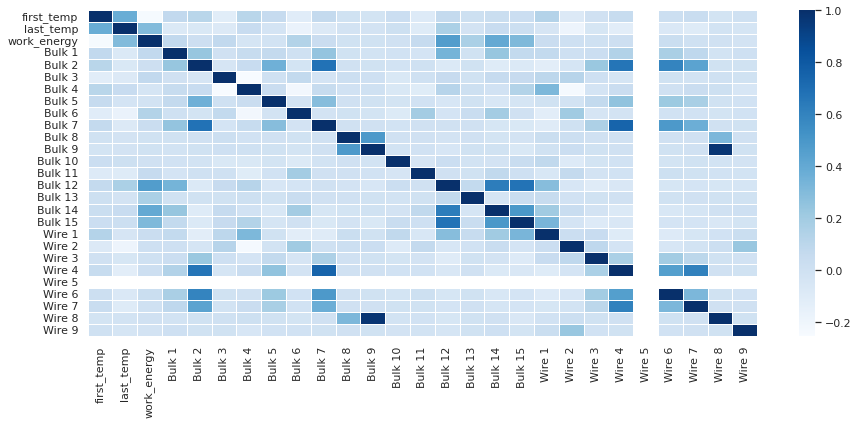

In [80]:
corr = data.corr()
sns.heatmap(corr, cmap="Blues", linewidths=1)

Мы обнаружили крайне сильную корреляцию между столбцами wire 8 и bulk 9.
Избавимся от одного из столбцов

In [81]:
data = data.drop(['Bulk 9'], axis=1)

<AxesSubplot:>

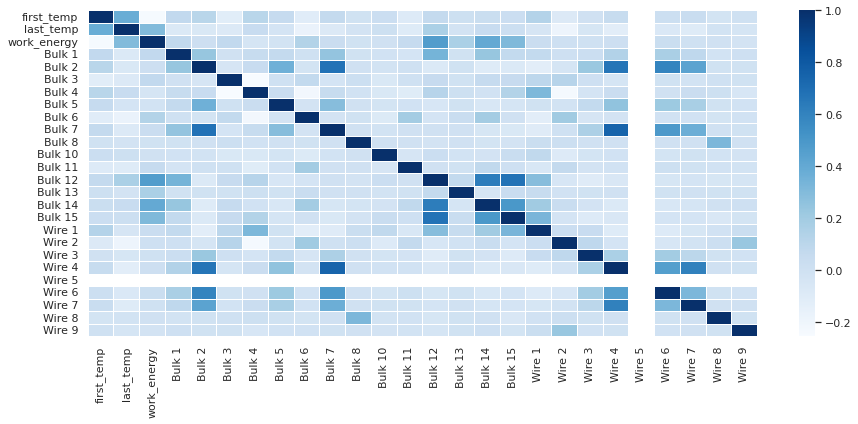

In [82]:
corr = data.corr()
sns.heatmap(corr, cmap="Blues", linewidths=1)

Между данными остались зависимости, но уже намного меньше.

### Разделение на обучающий и проверочный датасет

In [83]:
features = data.drop(['last_temp'], axis=1)
target = data['last_temp']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

### Масштабирование признаков

In [84]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_test)
pd.options.mode.chained_assignment = None

## Обучение моделей

### Линейная регрессия

In [85]:
% % time
lin_model = LinearRegression()
lin_model.fit(features_train, target_train)
predictions = lin_model.predict(features_test)
result = mean_absolute_error(predictions, target_test)
print("MAE:", result)

MAE: 7.382809468013469
CPU times: user 42.9 ms, sys: 26.5 ms, total: 69.5 ms
Wall time: 68.5 ms


Линейная регрессия показывает приемлемый результат, однако следует попробовать другие модели.

### Случайный лес

In [86]:
scorer = make_scorer(mean_absolute_error)

In [87]:
% % time
RandomForest_params_model = RandomForestRegressor(random_state=42)
parametrs = {'n_estimators': range(50, 201, 15),
             'max_depth': range(2, 8, 2)}
grid = GridSearchCV(RandomForest_params_model, parametrs, cv=5, scoring=scorer)
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 2, 'n_estimators': 65}
CPU times: user 1min 20s, sys: 270 ms, total: 1min 20s
Wall time: 1min 21s


In [88]:
RandomForest_model = RandomForestRegressor(
    random_state=42, **grid.best_params_)

In [89]:
% % time
RandomForest_model.fit(features_train, target_train)
RandomForest_predictions = RandomForest_model.predict(features_test)
result = mean_absolute_error(RandomForest_predictions, target_test)
print("MAE:", result)

MAE: 8.008851684281337
CPU times: user 193 ms, sys: 4.02 ms, total: 197 ms
Wall time: 204 ms


Случайный лес показывает результат хуже линейной регрессии.

### LightGBM

In [90]:
train_data = lightgbm.Dataset(features_train, label=target_train)
test_data = lightgbm.Dataset(features_test, label=target_test)

parameters = {
    'metric': 'mae',
    'boosting': 'gbdt',
    'max_leaves': 10,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'learning_rate': 0.005
}

LightGBM_model = lightgbm.train(
    parameters, train_set=train_data, valid_sets=test_data, num_boost_round=1800)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1791
[LightGBM] [Info] Number of data points in the train set: 1952, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1595.090676
[1]	valid_0's l1: 9.85622
[2]	valid_0's l1: 9.83533
[3]	valid_0's l1: 9.81462
[4]	valid_0's l1: 9.79539
[5]	valid_0's l1: 9.77589
[6]	valid_0's l1: 9.75769
[7]	valid_0's l1: 9.73958
[8]	valid_0's l1: 9.72156
[9]	valid_0's l1: 9.70367
[10]	valid_0's l1: 9.68592
[11]	valid_0's l1: 9.66558
[12]	valid_0's l1: 9.64677
[13]	valid_0's l1: 9.62706
[14]	valid_0's l1: 9.60904
[15]	valid_0's l1: 9.58978
[16]	valid_0's l1: 9.57103
[17]	v

In [91]:
% % time
LightGBM_predictions = LightGBM_model.predict(features_test)
LightGBM_mae_value = mean_absolute_error(target_test, LightGBM_predictions)
print("MAE:", LightGBM_mae_value)

MAE: 5.898949691026679
CPU times: user 111 ms, sys: 149 µs, total: 111 ms
Wall time: 89.9 ms


Модель на базе LightGBM позволяет делать предсказания с MAE меньше 6. Эта модель будет считаться итоговой.

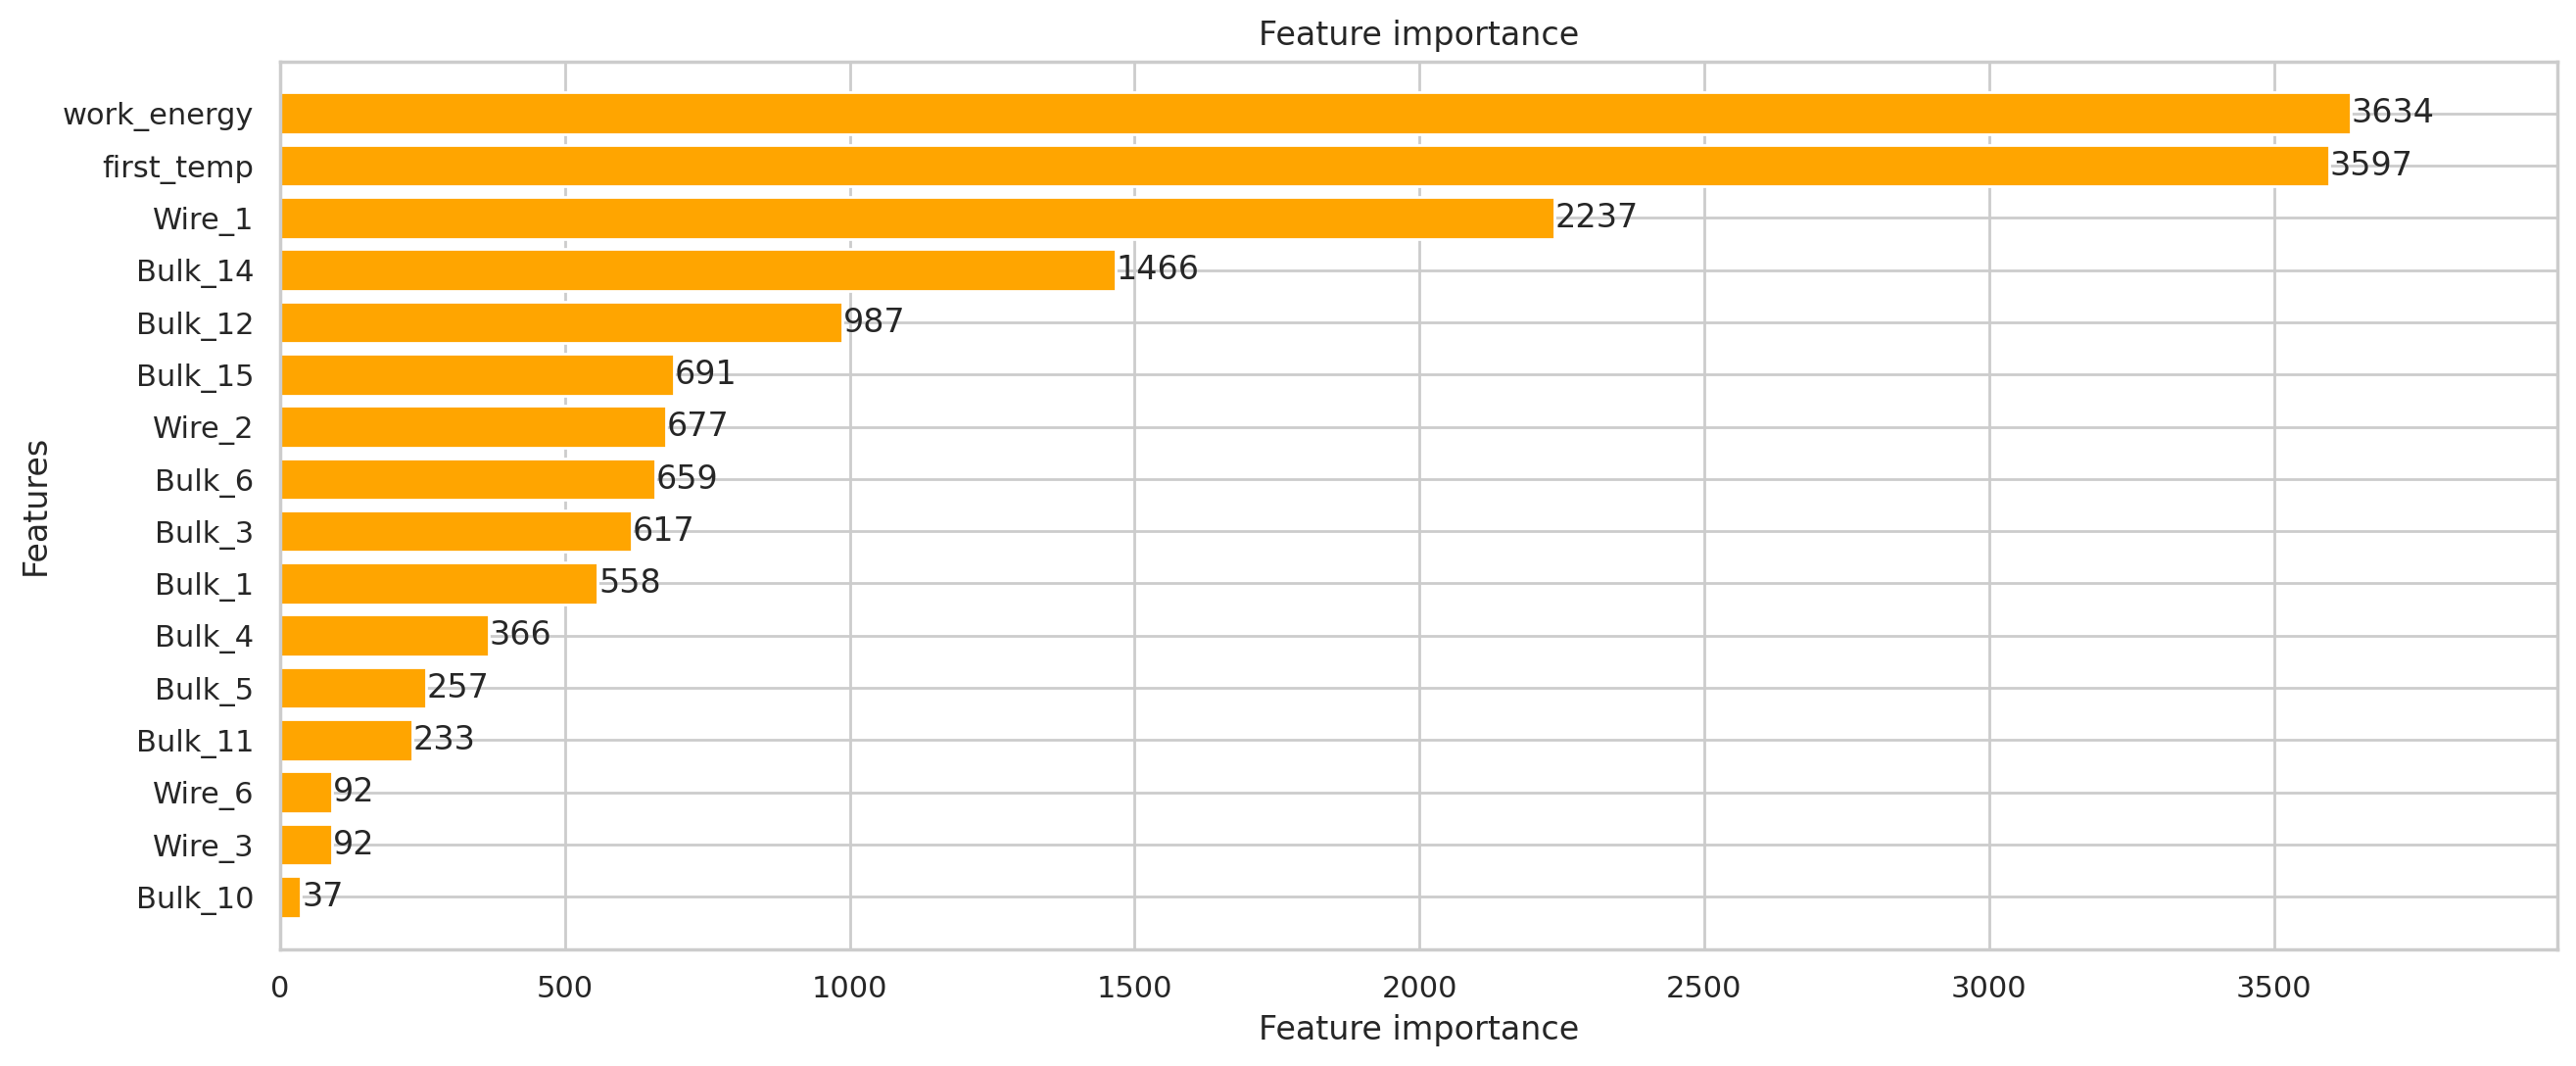

In [92]:
lightgbm.plot_importance(LightGBM_model, height=0.8, color='orange', dpi=200)
plt.show()

На графике выше указаны значения важности признаков. В соответствии с графиком ключевыми признаками для предсказания являются: изначальная темпаратура и кол-во переданной энергии на нагрев.

# Отчет

<b> Задача проекта</b>: Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

<b> Выполненные работы: </b> 

1. Были изучены и проанализированы предоставленные файлы с данными. Был определен целевой признак, который должна предсказывать модель, а именно - результат последнего замера темпартуры для партии. Выявленные сложности на этапе: не для каждой партии был известен первый и послений замер температуры стали; многие данные, касающиеся добавления сыпучих и проволочных материалов выходили за временные рамки первого и последнего замера температуры стали; данные о продувке газом не имели временного признака, из-за чего эти данные нельзя было использовать.
2. С учетом проводенного анализа были вычищены нерелевантные данные, создан новый признак - сумма переданной энергии на нагревание партии, сформирован единый датасет данных, необходимый для обучения модели.
3. Для наилучшего обучения модели произведено масштабирование признаков, удалены признаки с высокой взаимной корреляцией.
4. Датасет был разделен на две выборки: обучающую и проверочную.
5. На обучающей выборки были обучены три модели: линейная регрессия, случайный лес и LightGBM. Наилучший результат на проверочной выборке с точки зрения точности покзала модель LightGBM. Наихудшие результаты с точки зрения времени, потраченного на обучение, и точности показал случайный лес.
6. Итоговой моделью выбрана LightGBM.

<b> Результаты проекта: </b> Построена модель, способная предсказывать конечную температуру стали в ковше на основании начальной температуры, количества энергии, переданной на подогрев стали, а также объема добавленных легирующих добавок. Средняя ошибка модели (mean absolute error) составляет 5,9 градусов. Иными словами, внедрение данной модели позволит ООО «Так закаляем сталь» тратить ровно столько энергии, сколько необходимо не больше для достижения требуемой температуры стали со средней погрешностью 6 градусов.

<b>Рекомендуемые следующие шаги: </b> Ожидаемо модель продемонстировала, что самыми важными факторами, влияющими на конечную температуру являются: изначальная температура и количество энергии, переданной на нагревание. Таким образом, чтобы достигнуть наилучших результатов по снижению затрачиваемой энергии на этапе обработки стали, необходимо добиться оптимальной изначальной температуры. Следует начать с определния факторов, влияющих на значение начальной температуры на предыдущих этапах производства. Определив факторы, необходимо выявить возоможности для оптимизации и сохранения оптимальной температуры до этапа обработки стали с наименьшими затратами для компании. После этого, следует разработать список мероприятий для внедрения.